University of Helsinki, Master's Programme in Data Science  
DATA20019 Trustworthy Machine Learning, Autumn 2019  
Antti Honkela and Razane Tajeddine  

# Project 1: Local differential privacy for privacy-preserving data analysis

Deadline for returning the solutions: 11 November 23:55.

Python is recommended for solving the problems and it is supported by the course. If you wish, you can use R, but we cannot guarantee support for technical problems in R.

## General instructions (IMPORTANT!)

1. This is an individual project. You can discuss the solutions with other students, but everyone needs to write their own code and answers.
2. Please return your solutions as a notebook. When returning your solutions, please leave all output in the notebook.
3. When returning your solutions, please make sure the notebook can be run cleanly using "Cell" / "Run All".
4. Please make sure there are no dependencies between solutions to different problems.
5. Please make sure that your notebook will not depend on any local files.
6. Please make sure that the solutions for each problem in your notebook will produce the same results when run multiple times, i.e. remember to seed any random number generators you use (`numpy.random.seed()`!).



## Task 1: Do you use illegal drugs?

Let us consider the so-called "randomised response" mechanism for collecting responses to a potentially embarrassing or private question. In this mechanism, the respondents are instructed to as follows:

1. Flip a coin.
2. If **tails**, then respond truthfully.
3. If **heads**, then flip a second coin and respond *Yes* if heads and *No* if tails.

i. Calculate the probability of the randomised response being "yes" and the probability of the randomised response being "no", conditional to true response being "yes"/"no".

ii. Verify that this mechanism satisfies local $\epsilon$-DP with $\epsilon = \ln 3$.

iii. Assuming a population of independent respondents who have the probability $\pi$ to answer yes. Design a method to estimate $\pi$ from the noisy responses. Simulate the mechanism with $n$ participants for $n = 10, 100, 1000, 10000$ with $\pi = 0.01, 0.1$. How accurately can you estimate $\pi$ in the different cases?


In [1]:
import numpy as np
# 1

P_YES_YES = .5 + .5 * .5
P_YES_NO = .5 * .5
assert(P_YES_YES + P_YES_NO == 1)

P_NO_NO = .5 + .5 * .5
P_NO_YES = .5 * .5
assert(P_NO_NO + P_NO_YES == 1)

p_arr = np.array([
    [P_YES_YES, P_YES_NO],
    [P_NO_YES, P_NO_NO]
])

print(p_arr)


[[0.75 0.25]
 [0.25 0.75]]


In [2]:
np.random.seed(666)

ns = [10, 100, 1000, 10000]
ps = [0.01, 0.1]

for n in ns:
    for p in ps:
        yeses = 0
        nos = 0
        true_yes = 0
        for i in range(n):
            coin_1 = np.random.uniform(0, 1)
            if coin_1 > .5:
                # True answer
                yes_man = np.random.uniform(0, 1) < p
                if yes_man:
                    true_yes += 1
                    yeses += 1
                else:
                    nos += 1
            else:
                coin_2 = np.random.uniform(0, 1) > .5
                
                if coin_2:
                    yeses += 1
                else:
                    nos += 1
                    
        print(yeses, nos, true_yes, 'FOR', n, p)
                    
                


4 6 0 FOR 10 0.01
2 8 0 FOR 10 0.1
21 79 2 FOR 100 0.01
34 66 5 FOR 100 0.1
255 745 4 FOR 1000 0.01
292 708 39 FOR 1000 0.1
2542 7458 57 FOR 10000 0.01
2994 7006 502 FOR 10000 0.1


## Task 2: Generalising randomised response

Consider a generalised randomised response mechanism, where each person flips $k$ coins in step 1 and responds truthfully if either  
i. all of them display tails  
ii. any one of them displays tails.

Verify that both of these produce $\epsilon$-DP mechanisms for each $k$. Evaluate and plot $\epsilon$ as a function of $k$ for each case and $k = 1, \dots, 10$.

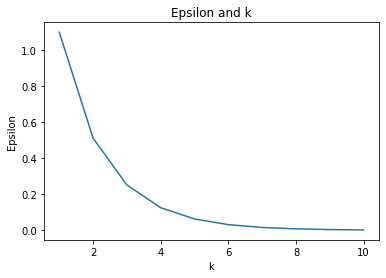

In [9]:
import matplotlib.pyplot as plt
epsilons = []

for k in range(1,11):
    P_YES_YES = .5**k + (1 - .5**k) * .5
    P_YES_NO = (1 - .5**k) * .5
    assert(P_YES_YES + P_YES_NO == 1)
    
    epsilons.append(np.log(P_YES_YES / P_YES_NO))
    
plt.plot(range(1,11), epsilons)
plt.ylabel('Epsilon')
plt.xlabel('k')
plt.title('Epsilon and k')
plt.show()

'All of the coin tosses display tails' is the complement of 'Any of the coin tosses display heads'.

Similarly the statement 'Any of the tosses display tails' is the complement of 'All of the tosses display heads'. 

So all these statements will provide the same values as the event has probability of 1 / 2.

## Task 3: How much money do you have on your bank account?

To answer a question about a scalar value, we need a different mechanism. Here we use the Laplace mechanism, which works as follows:

* Evaluate the *sensitivity* of the function $f$ of interest:
$$ \Delta f = \max\limits_{\mathcal{D} \sim \mathcal{D}'} | f(\mathcal{D}) - f(\mathcal{D}') |, $$
where $\mathcal{D} \sim \mathcal{D}'$ denotes pairs of data sets that differ by a single sample.
* Compute $\mathcal{M}(\mathcal{D}) = f(\mathcal{D}) + \frac{\Delta f}{\epsilon} \eta$
where $\eta \sim \operatorname{Laplace}(0, 1)$

In this exercise we apply the Laplace mechanism in locally differentially private mode, i.e. each individual is assumed to form a different single-observation data set that is protected using this mechanism.

In order to estimate the mean of the distribution of data held by the users, we can use the following moment identities with $x$ denoting the user data and $z$ denoting the Laplace noise added for DP:
$$ \mathrm{E}[x + z] = \mathrm{E}[x] + \mathrm{E}[z], $$
$$ \mathrm{Var}[x + z] = \mathrm{Var}[x] + \mathrm{Var}[z]. $$

i) What is the probability $Pr(\mathcal{M}(\mathcal{D})=s)$ for some outcome $s$? Also, find the ratio $\frac{Pr(\mathcal{M}(\mathcal{D})=s)}{Pr(\mathcal{M}(\mathcal{D}')=s)}$.

ii) (Optional) Verify that this mechanism satisfies $\epsilon$-DP.

iii) Assuming a population of independent respondents whose bank account balances follow the exponential distribution $\mathrm{Exp}(\lambda)$ with $\lambda = 1/5000$. Simulate the mechanism for $n$ participants with $n = 10, 100, 1000, 10000$. How accurately can you estimate the mean and the standard deviation of the bank account balance distribution?
Repeat each simulation 100 times to get an idea of the accuracy.

Hint: you will need to set an upper bound on the allowed balances to get a bounded sensitivity. Larger values can be handled e.g. by setting them to the maximum. In order to guarantee DP, this bound should be selected independently of the actual data at hand. (Mechanisms that do not require such an a priori bound exist, but are more complicated. If you are interested, see e.g. https://dl.acm.org/citation.cfm?id=1250803.)


Real average for data = 4965.568963523633, std = 4463.321072006336


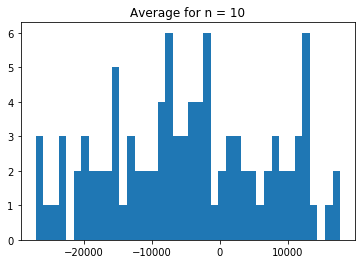

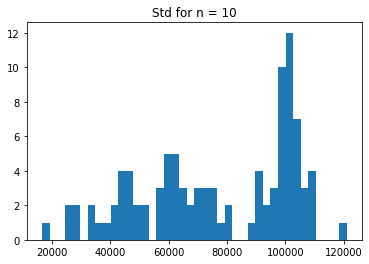

Real average for data = 5957.10590758289, std = 6273.78071232532


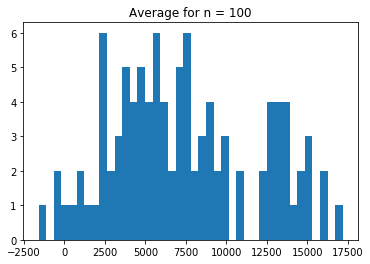

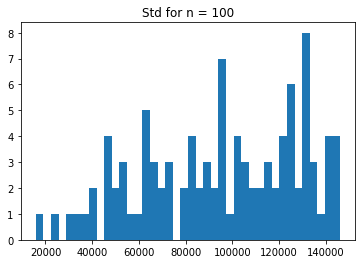

Real average for data = 4776.1170098086295, std = 4692.311047356293


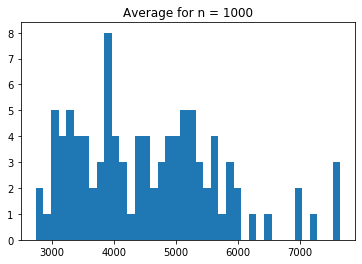

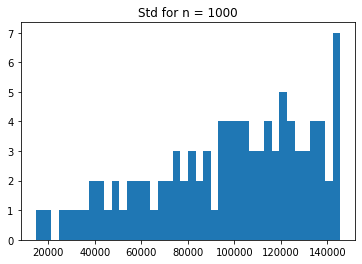

Real average for data = 4971.380213579947, std = 5028.445561582703


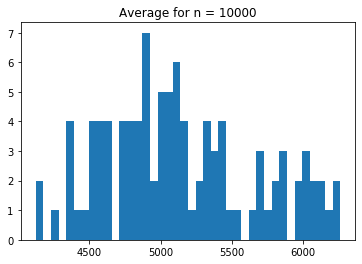

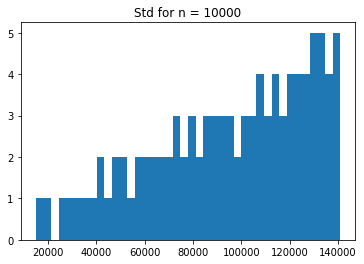

In [8]:
np.random.seed(666)
max_money = 50_000
min_money = 0
epsilon = 5
sensitivity = max_money - min_money

for n in [10, 100, 1000, 10_000]:
    data = np.clip(np.random.exponential(5000, n), min_money, max_money)
    avgs = []
    stds = []
    print(f'Real average for data = {np.average(data)}, std = {np.std(data)}')
    for _ in range(100):
        data = data + np.random.laplace(0, 1, n) * (sensitivity / epsilon)
        avgs.append(np.average(data))
        stds.append(np.std(data))
        
    plt.hist(avgs, bins=40)
    plt.title('Average for n = ' + str(n))
    plt.show()
    plt.hist(stds, bins=40)
    plt.title('Std for n = ' + str(n))
    plt.show()



## Task 4: Does your age affect your account balance?

We can apply the Laplace mechanism to fit a linear regression model to model the bank account balance as a function of age. We know that the respondents are of age 20-70 years and their account balances are at most 150000.

Linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming regression errors $\epsilon_i$ are normally distributed, the maximum likelihood estimates of the parameters are
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i = 1}^n (x_i - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x_i$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y_i$.

i. Use the data in "balances.csv" loaded below, and release $x$ (the age) and $y$ (the bank account balance) using Laplace mechanism with total privacy loss $\epsilon=1$ and fit the regression model to the noisy data. Repeat the process 100 times and evaluate how the model compares with one learned from clean data. Because you are releasing the composition of two queries, you will need to use $\epsilon/2$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

ii. Design a two-step protocol that first estimates the means $\bar{x}$ and $\bar{y}$, and then uses these to release the terms $(x_i - \bar{x}) (y_i - \bar{y})$, $(x_i - \bar{x})^2$ using the Laplace mechanism. Fit the regression model using the noisy information. Compare with the above. In order to make the results comparable, the total privacy loss should be $\epsilon=1$. Because you are releasing the composition of four queries, you will need to use $\epsilon/4$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

iii. Repeat the above cases with total privacy loss $\epsilon = 10$ and compare the results.

Hint: you can use the known range of values of $x$ and $y$ to bound the sensitivites. For the two-step protocol, you can also use the published private means $\bar{x}$ and $\bar{y}$ to evaluate the sensitivity for the second step, as long as you do not use any other features of the specific data set.

Comment: a better solution would take into account the knowledge of the noise added. Developing algorithms like this is in many cases still an open research problem. Furthermore, the privacy budget can be split between different queries arbitrarily, not necessarily evenly like here.

Epsilon is 1


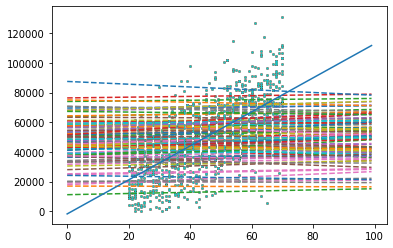

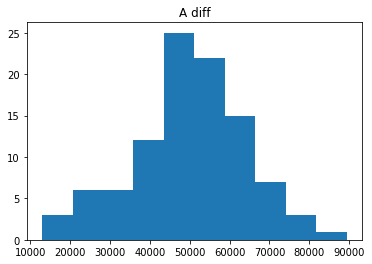

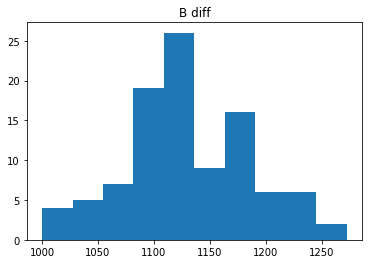

Epsilon is 10


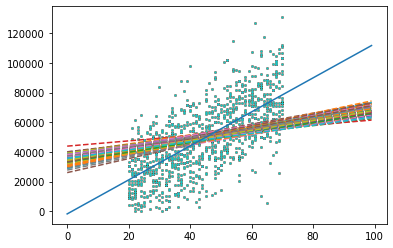

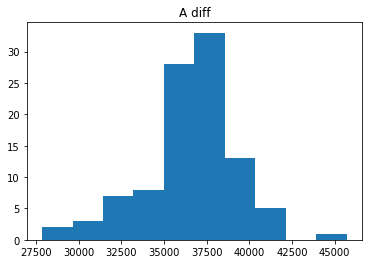

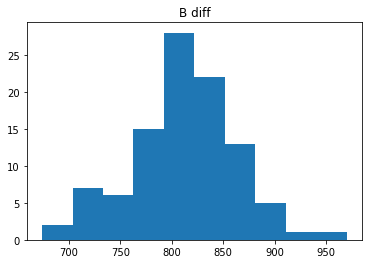

Epsilon is 50


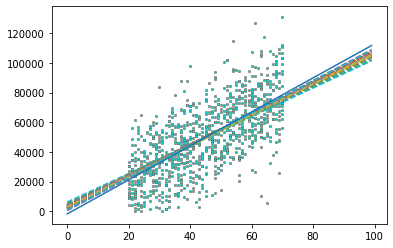

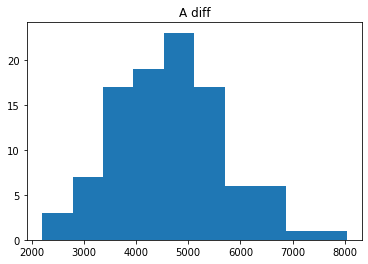

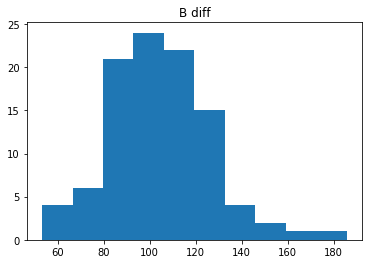

In [130]:
np.random.seed(666)
import numpy as np
import numpy.random as npr
import pandas as pd

data = pd.read_csv('https://www.cs.helsinki.fi/u/ahonkela/teaching/tml/balances.csv', header=0, index_col=0)

x = data.values[:,0]
y = data.values[:,1]
N = len(data)



def fit_model(x, y):
    x_avg = np.average(x)
    y_avg = np.average(y)
    b_hat = np.sum((x - x_avg) * (y - y_avg) / np.sum((x - x_avg)**2))
    a_hat = y_avg - b_hat * x_avg
    
    return b_hat, a_hat

b_hat_orig, a_hat_orig = fit_model(x, y)

def add_noise(x, sens, eps):
    return x + np.random.laplace(0, 1, len(x)) * (sens / eps)

# 80 - 0
x_sens = 80
# 150_000 - 0
y_sens = 150_000
for epsilon in [1, 10, 50]:
    print('Epsilon is', epsilon)
    a_hat_diff = []
    b_hat_diff = []
    for _ in range(100):
        noisy_x = add_noise(np.clip(x, 0, x_sens), x_sens, epsilon / 2)
        noisy_y = add_noise(np.clip(y, 0, y_sens), y_sens, epsilon / 2)
        b_hat, a_hat = fit_model(noisy_x, noisy_y)

        a_hat_diff.append(np.abs(a_hat - a_hat_orig))
        b_hat_diff.append(np.abs(b_hat - b_hat_orig))
        plt.plot(range(0, 100), b_hat * range(0, 100) + a_hat,  ls='--')
        plt.scatter(x, y, marker='x', s=1)

    plt.plot(range(0, 100), b_hat_orig * range(0, 100) + a_hat_orig)
    plt.show()

    plt.hist(a_hat_diff)
    plt.title('A diff')
    plt.show()
    plt.hist(b_hat_diff)
    plt.title('B diff')
    plt.show()



Epsilon is 1


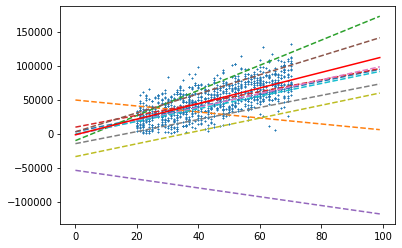

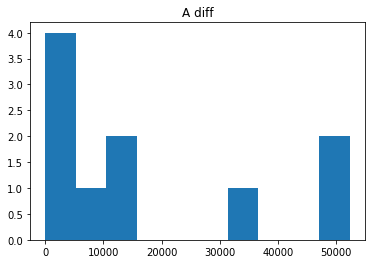

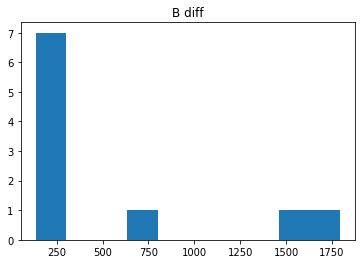

Epsilon is 10


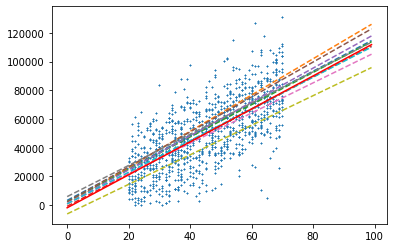

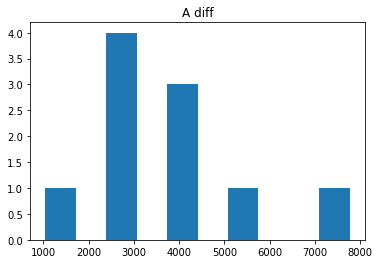

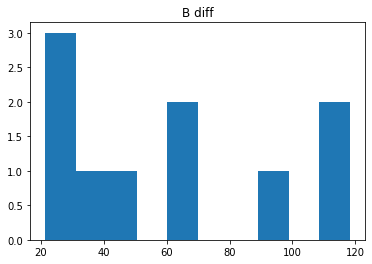

Epsilon is 50


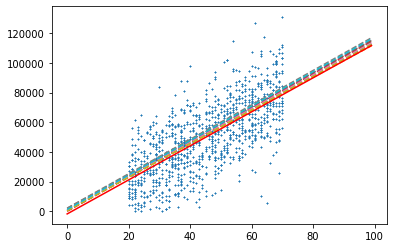

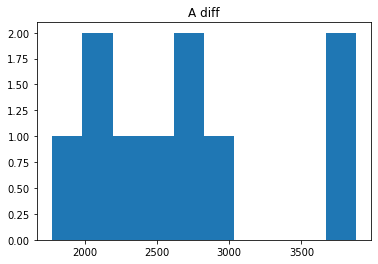

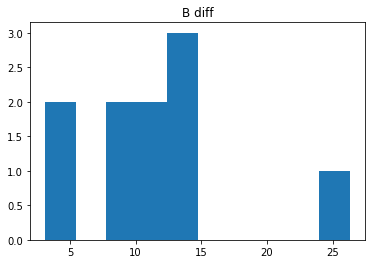

In [132]:
np.random.seed(666)

for epsilon in [1, 10, 50]:
    print('Epsilon is', epsilon)
    a_hat_diff = []
    b_hat_diff = []
    for _ in range(10):
        x_clip = np.clip(x, 0, x_sens)
        y_clip = np.clip(y, 0, y_sens)
        x_avg = np.average(add_noise(x_clip, x_sens, epsilon / 4))
        y_avg = np.average(add_noise(y_clip, y_sens, epsilon / 4))

        two_noisy_1 = np.sum(add_noise((x_clip - x_avg) * (y_clip - y_avg), (x_avg / 2) * (y_avg / 2), epsilon/4))
        two_noisy_2 = np.sum(add_noise((x_clip - x_avg) ** 2, (x_avg / 2) ** 2, epsilon / 4))

        b_hat_two_step = two_noisy_1 / two_noisy_2
        a_hat_two_step = y_avg - b_hat * x_avg

        a_hat_diff.append(np.abs(a_hat_two_step - a_hat_orig))
        b_hat_diff.append(np.abs(b_hat_two_step - b_hat_orig))


        plt.plot(range(0, 100), b_hat_two_step * range(0, 100) + a_hat_two_step,  ls='--')

    plt.plot(range(0, 100), b_hat_orig * range(0, 100) + a_hat_orig, c='red')
    plt.scatter(x, y, marker='x', s=1)
    plt.show()
    plt.hist(a_hat_diff)
    plt.title('A diff')
    plt.show()
    plt.hist(b_hat_diff)
    plt.title('B diff')
    plt.show()